# Changing Hearts and Minds

This is one of the Jupyter notebooks I used in my preparation of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

Before you read these notebooks, please keep in mind:

* There is some explanatory text here, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/progress.ipynb).

In [ ]:
# Install empirical dist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [19]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    set_pyplot_params,
    underride,
    decorate,
    decorate_table,
    prepare_yvar,
    run_subgroups,
    chunk_series,
    make_table,
    visualize_table,
    label_table,
    label_table_left,
    make_lowess,
    plot_series_lowess,
)

In [21]:
# Set the random seed so we get the same results every time
np.random.seed(17)


In 1950, the physicist Max Planck made a bleak assessment of progress in science.
He wrote, "A new scientific truth does not triumph by convincing its opponents and making them see the light, but rather because its opponents eventually die, and a new generation grows up that is familiar with it."
Scientists often quote a pithier version attributed to economist Paul A. Samuelson: "Science progresses, one funeral at a time."
According to this view, science progresses by generational replacement alone, not changed minds.

I am not sure that Planck and Samuelson are right about science, but I don't have the data to check.
However, thanks to the General Social Survey (GSS), we have the data to assess a different kind of progress, the expansion of the "moral circle". 

The idea of the moral circle was introduced by historian William Lecky in *A History of European Morals from Augustus to Charlemagne*, published in 1867. He wrote:

> At one time the benevolent affections embrace merely the family, soon the circle expanding includes first a class, then a nation, then a coalition of nations, then all humanity, and finally, its influence is felt in the dealings of man with the animal world.

In this chapter we'll use data from the GSS to explore the moral circle, focusing on questions related to race, sex, and sexual orientation.
We'll find more examples of Simpson's paradox, which we saw in the previous chapter.
For example, older people are more likely to hold racist views, but that doesn't mean people become more racist as they get older.
To interpret this result and others like it, I'll introduce a tool called age-period-cohort analysis and a concept called the Overton window.

Let's start with race.

## Old Racists?

Stereotypes suggest that older people are more racist than young people.
To see whether that's true, I'll use responses to three questions in the General Social Survey related to race and public policy:

> 1. Do you think there should be laws against marriages between 
(Negroes/Blacks/African-Americans) and whites?
>
> 2. If your party nominated a (Negro/Black/African-American) for President, 
would you vote for him if he were qualified for the job?
>
> 3. Suppose there is a community-wide vote on the general housing issue. There are two possible laws to vote on. Which law would you vote for? 
>
>     * One law says that a homeowner can decide for himself whom to sell his house to, even if he prefers not to sell to [people of a particular race].
>
>     * The second law says that a homeowner cannot refuse to sell to someone because of their race or color.
>

I chose these questions because they were added to the survey in the early 1970s and they have been asked almost every year since.
The words in parentheses indicate that the wording of these questions has changed over time to use contemporary terms for racial categories.

The following figure shows the responses to these questions as a function of the respondents' ages.
To make it easy to compare answers to different questions, the $y$ axis shows the percentage who chose what I characterize as the racist responses: that interracial marriage should be illegal; that the respondent would not vote for a black presidential candidate; and that it should be legal to refuse to sell a house to someone based on their race.

The results vary from year to year, so I've plotted a smooth curve to fit the data.

In [22]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

filename = "gss_eds.3.hdf"
download(DATA_PATH + filename)

In [23]:
gss = pd.read_hdf(filename, "gss0")
gss.shape

(68846, 205)

In [24]:
bins = np.arange(1889, 2011, 10)
labels = bins[:-1] + 1

gss["cohort10"] = pd.cut(gss["cohort"], bins, labels=labels).astype(float)
gss["cohort10"].value_counts().sort_index()

cohort10
1890.0      455
1900.0     1717
1910.0     3663
1920.0     5959
1930.0     6992
1940.0    10777
1950.0    13981
1960.0    10724
1970.0     7286
1980.0     4499
1990.0     2022
2000.0      202
Name: count, dtype: int64

In [25]:
gss.dropna(subset=["cohort10"], inplace=True)
gss["cohort10"] = gss["cohort10"].astype(int)

Start with an empty DataFrame and add columns for the 10 questions used in this chapter.

In [26]:
ten_questions = pd.DataFrame(gss["year"])

In [27]:
xvarname = "age"
yvarname = "racmar"
gvarname = "cohort10"
yvalue = 1

prepare_yvar(gss, yvarname, yvalue)
ten_questions["r1"] = gss["y"]
series_racmar = chunk_series(gss, xvarname) * 100

In [28]:
xvarname = "age"
yvarname = "racpres"
gvarname = "cohort10"
yvalue = 2  # would not vote

prepare_yvar(gss, yvarname, yvalue)
ten_questions["r2"] = gss["y"]
series_racpres = chunk_series(gss, xvarname) * 100

In [29]:
xvarname = "age"
yvarname = "racopen"
gvarname = "cohort10"
yvalue = 1  # would vote for the wrong law

prepare_yvar(gss, yvarname, yvalue)
ten_questions["r3"] = gss["y"]
series_racopen = chunk_series(gss, xvarname) * 100

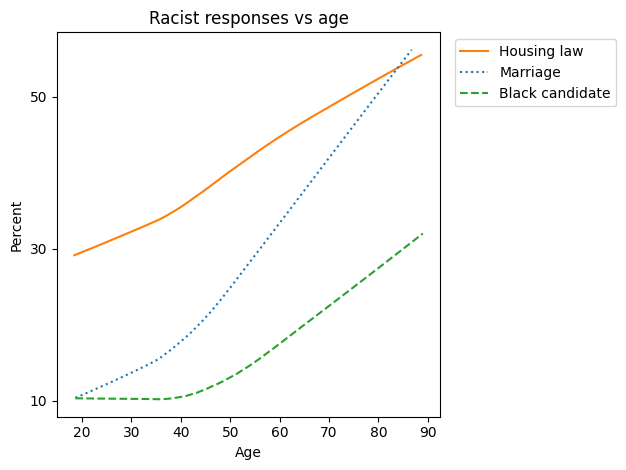

In [30]:
plot_series_lowess(series_racopen, ls="-", color="C1", label="Housing law")
plot_series_lowess(series_racmar, ls=":", color="C0", label="Marriage")
plot_series_lowess(
    series_racpres, ls="--", color="C2", label="Black candidate"
)

decorate(xlabel="Age", ylabel="Percent", title="Racist responses vs age")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.yticks([10, 30, 50])
plt.tight_layout();

For all three questions, old people are substantially more likely to choose the racist response, so there is some truth to the stereotype.

But that raises a question: do people *become* more racist as they age, or do they persist in the beliefs they were raised with?
We can answer that with another view of the data.

The following figure shows responses to the first question, about interracial marriage, grouped by decade of birth and plotted by age.

In [31]:
xvarname = "age"
yvarname = "racmar"
gvarname = "cohort10"
yvalue = 1

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)
table[1980]

age
19.868421    1.315789
Name: 1980, dtype: float64

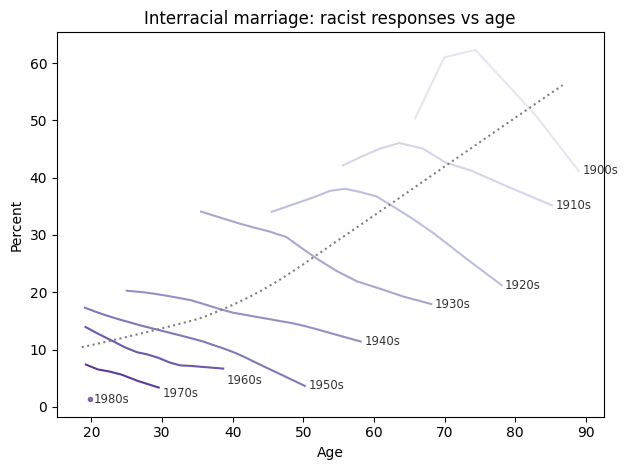

In [32]:
visualize_table(series_racmar, table, plot_series=False)

nudge = {"1970s": -1, "1960s": -2}
label_table(table, nudge)
decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Interracial marriage: racist responses vs age",
    legend=False,
)

The dotted line shows the trend for all respondents; as we saw in the previous figure, older respondents are more likely to favor a law against interracial marriage.
But that doesn't mean that people are more likely to adopt this view as they age.
In fact, it's the opposite: in almost every birth cohort, people age out of racism.

So this is another example of Simpson's paradox: within the groups, the trend is downward as a function of age, but overall, the trend is upward.
The reason is that, because of the design of the GSS, we observe different cohorts at different ages.
At the left side of the figure, the overall average is low because the youngest people surveyed are mostly from the most recent generations; at the right side, the overall average is high because the older people are mostly from the earliest generations.

You might notice that we have only one observation for people born in the 1980s and no data for people born in the 1990s.
That's because this question was dropped from the GSS after 2002.
At that point, the percentage of people in favor of the law, and willing to say so, had dropped below 10%.
Among people born in the 1980s, it was barely 1%.

At that point, the GSS had several reasons to retire the question.
First, as a matter of public policy, the matter was resolved in 1967 by the U.S. Supreme Court decision in *Loving v. Virginia*; by the 1990s it was no longer part of mainstream political discussion.
Second, because the responses were so one-sided, there was little to learn by asking.
And finally, estimating small proportions from survey data is unreliable due to a phenomenon known as "lizard people".

The term comes from a notorious poll conducted in 2013 by Public Policy Polling, which included questions about a variety of conspiracy theories.
One asked:

> Do you believe that shape-shifting reptilian people control our world by taking on human form and gaining political power to manipulate our societies, or not?

Of 1247 registered voters who responded, 4% said yes.
If that is an accurate estimate of the prevalence of this belief, it implies that there are more than 12 million people in the U.S. who believe in lizard people.

But it is probably not an accurate estimate, because of a problem well known to survey designers.
In any group of respondents, there will be some percentage who misunderstand a question, accidentally choose a response they did not intend, or maliciously choose a response they do not believe.
And in this example, there were probably a few open-minded people who had never heard of lizard people in positions of power, but once the survey raised the possibility, they were willing to entertain it. 

Errors like this are tolerable when the actual prevalence is high. 
In that case, the number of errors is small compared to the number of legitimate positive responses.
But when the actual prevalence is low, there might be more false positive responses than true ones.
If 4% of respondents endorsed the lizard-people theory in error, the actual prevalence might be zero.

The point of this diversion is that it is hard to measure small percentages with survey data, which is one reason the GSS stops asking about rare beliefs.

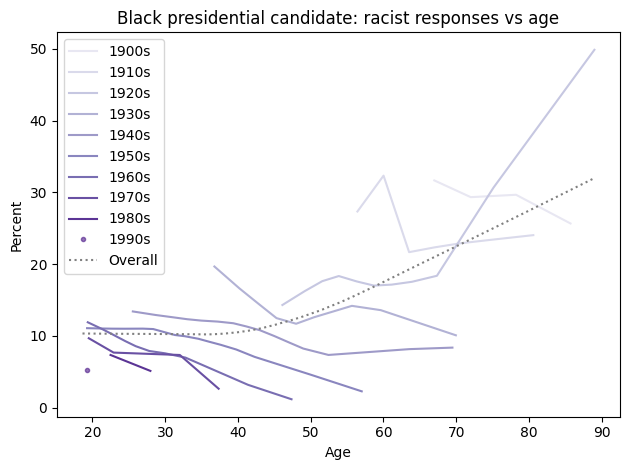

In [33]:
xvarname = "age"
yvarname = "racpres"
gvarname = "cohort10"
yvalue = 2

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)

visualize_table(series_racpres, table, plot_series=False)

decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Black presidential candidate: racist responses vs age",
)

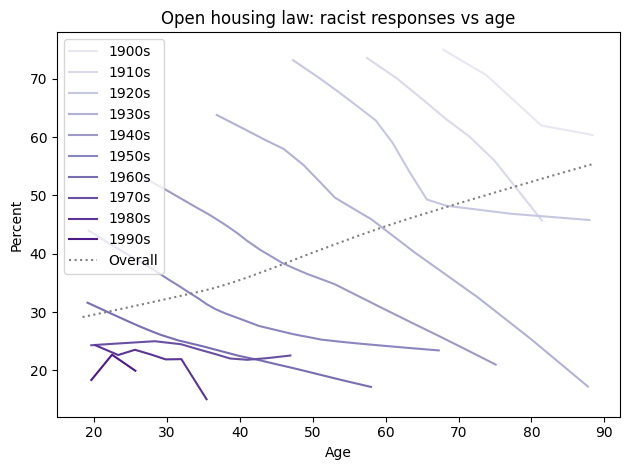

In [34]:
xvarname = "age"
yvarname = "racopen"
gvarname = "cohort10"
yvalue = 1  # would vote for the wrong law

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)

visualize_table(series_racopen, table, plot_series=False)
decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Open housing law: racist responses vs age",
)

The responses to the other two questions follow the same pattern.

* Asked whether they would vote for a qualified Black presidential candidate nominated by their own party, older people were more likely to say no. But within every birth cohort, people were more likely to say yes as they got older.

* Asked whether they would support an open housing law, older people were more likely to say no. But within every birth cohort, people were more likely to say yes as they got older.

So, even if you observe that older people are more likely to hold racist beliefs, that doesn't mean people become more racist with age.
In fact, the opposite is true: in every generation, going back to 1900, people grew less racist over time.

In [35]:
xvarname = "age"
yvarname = "racopen"
gvarname = "cohort10"
yvalue = 1  # would vote for the wrong law

prepare_yvar(gss, yvarname, yvalue)
gss.query("age >= 70")["y"].mean(), gss.query("age <= 30")["y"].mean()

(0.5165211970074813, 0.3089821763602251)

In [36]:
xvarname = "age"
yvarname = "racpres"
gvarname = "cohort10"
yvalue = 2  # would not vote for a black candidate

prepare_yvar(gss, yvarname, yvalue)
gss.query("age >= 70")["y"].mean(), gss.query("age <= 30")["y"].mean()

(0.24651372019793072, 0.10303030303030303)

## Young Feminists

Similarly, older people are more likely to hold sexist beliefs, but that doesn't mean people become more sexist as they age.
The GSS includes three questions related to sexism:

> 1. Please tell me whether you strongly agree, agree, disagree, or strongly disagree [...]: It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family.
>
> 2. Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women. 
>
> 3. If your party nominated a woman for President, would you vote for her if she were qualified for the job?

The following figure shows the results as a function of the respondents' ages.
Again, the $y$ axis shows the percentage of respondents who chose what I characterize as a sexist response: that it is much better for everyone if women stay home, that men are more suited emotionally for politics, and that the respondent would not vote for a female presidential candidate.

In [37]:
# [1977-2021]
# [1974-2021]
# [1972-2010]

In [38]:
xvarname = "age"
yvarname = "fefam"
gvarname = "cohort10"
yvalue = [1, 2]  # strongly agree or agree

prepare_yvar(gss, yvarname, yvalue)
ten_questions["f1"] = gss["y"]
series_fefam = chunk_series(gss, xvarname) * 100

In [39]:
xvarname = "age"
yvarname = "fepol"
gvarname = "cohort10"
yvalue = 1  # agree

prepare_yvar(gss, yvarname, yvalue)
ten_questions["f2"] = gss["y"]
series_fepol = chunk_series(gss, xvarname) * 100

In [40]:
xvarname = "age"
yvarname = "fepres"
gvarname = "cohort10"
yvalue = 2  # would not vote

prepare_yvar(gss, yvarname, yvalue)
ten_questions["f3"] = gss["y"]
series_fepres = chunk_series(gss, xvarname) * 100

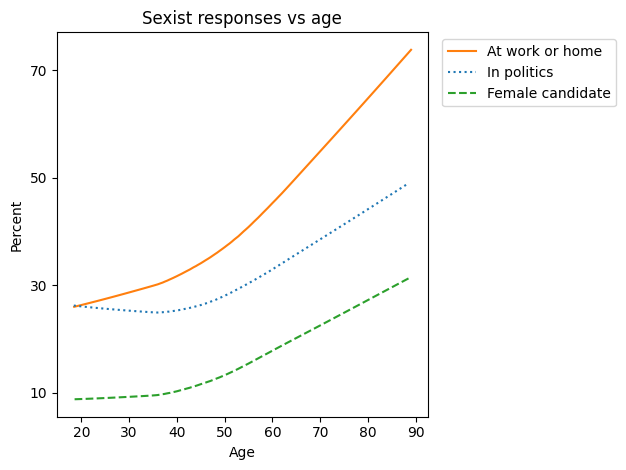

In [41]:
plot_series_lowess(series_fefam, ls="-", color="C1", label="At work or home")
plot_series_lowess(series_fepol, ls=":", color="C0", label="In politics")
plot_series_lowess(
    series_fepres, ls="--", color="C2", label="Female candidate"
)

decorate(xlabel="Age", ylabel="Percent", title="Sexist responses vs age")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.yticks([10, 30, 50, 70])
plt.tight_layout();

For all three questions, older people are more likely to choose the sexist response.
The difference is most dramatic for the first question, related to women working outside the home.
The difference is smaller for the other questions, although that is in part because the third question, related to voting for a female presidential candidate, was retired after 2010 as the prevalence dropped into lizard people territory.

The following figure shows responses to the second question grouped by decade of birth and plotted by age.

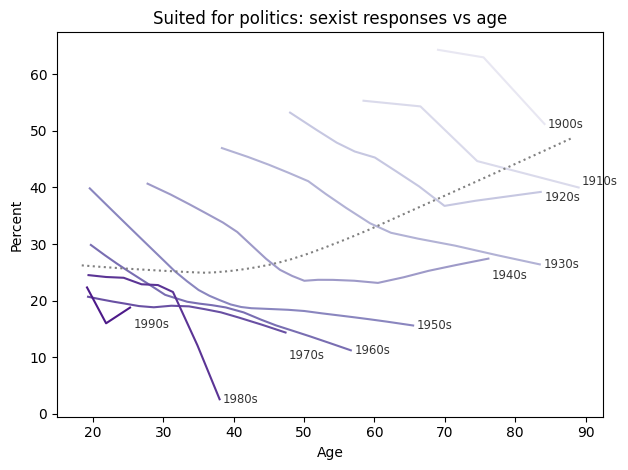

In [42]:
xvarname = "age"
yvarname = "fepol"
gvarname = "cohort10"
yvalue = 1

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)

visualize_table(series_fepol, table, plot_series=False)
nudge = {"1990s": -3, "1970s": -4, "1940s": -3, "1920s": -1, "1910s": 1}
label_table(table, nudge)

decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Suited for politics: sexist responses vs age",
    legend=False,
)

Overall, older people are more likely to be sexist, but within almost every cohort, people become less sexist as they get older.
The results from the other two questions show the same pattern.

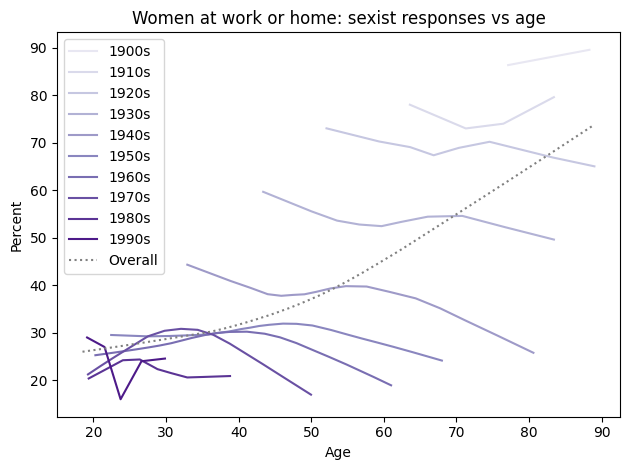

In [43]:
xvarname = "age"
yvarname = "fefam"
gvarname = "cohort10"
yvalue = [1, 2]  # strongly agree or agree

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)

visualize_table(series_fefam, table, plot_series=False)

decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Women at work or home: sexist responses vs age",
)

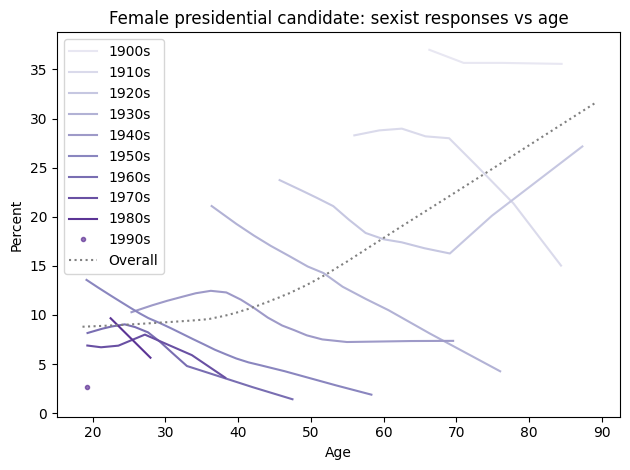

In [44]:
xvarname = "age"
yvarname = "fepres"
gvarname = "cohort10"
yvalue = 2  # would not vote

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)

visualize_table(series_fepres, table, plot_series=False)

decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Female presidential candidate: sexist responses vs age",
)

As in the previous examples, the reason is that the younger respondents are more likely to belong to recent birth cohorts, which are less sexist, and the older respondents are more likely to belong to earlier birth cohorts, which are more sexist.

This example demonstrates the difference between an "age effect" and a "cohort effect"; in general, there are three ways populations change over time:

* An "age effect" is something that affects most people at a particular age or life stage. Age effects can be biological, like the loss of deciduous teeth, or social, like the loss of youthful innocence.

* A "period effect" is something that affects most people at a particular point in time. Period effects include notable events, like the September 11 attacks, or intervals like the Cold War.

* A "cohort effect" is something that affects people born at a particular time, usually due to the unique environment they grew up in. When people make generalizations about the characteristics of baby boomers and millennials, for example, they are appealing to cohort effects (often without much evidence).

It can be hard to distinguish between these effects.
In particular, when we see a cohort effect, it is easy to mistake it for an age effect.
When we see that older people hold particular beliefs, we might assume (or fear) that young people will adopt those beliefs as they age.
But age effects like that are rare.

Most people develop social beliefs based on the environment they are raised in, so that's primarily a cohort effect.
If those beliefs change over their lifetimes, it is most often because of something happening in the world, which is a period effect.
But it is unusual to adopt or change a belief when you reach a particular age.
Other than registering to vote when you are 18, most political acts don't depend on the number of candles on the cake.

The previous figure shows one way to distinguish cohort and age effects: grouping people by cohort and plotting their responses as a function of age.
Similarly, to distinguish cohort and period effects, we can group people by birth cohort, again, and plot their responses over time.
For example, the following figure shows responses to the first of the three questions, about whether everyone would be better off if women stayed home, plotted over time.

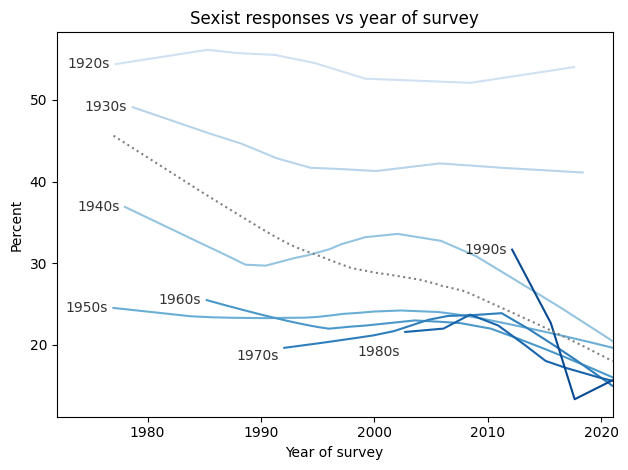

In [45]:
xvarname = "year"
yvarname = "fefam"
gvarname = "cohort10"
yvalue = 2

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)
del table[1900]
del table[1910]
series = chunk_series(gss, xvarname) * 100

visualize_table(series, table, plot_series=False, palette="Blues")

nudge = {"1970s": -1, "1980s": -2.5}
label_table_left(table, nudge)
decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Sexist responses vs year of survey",
    xlim=[1972, 2021],
    legend=False,
)

In this figure, there is evidence of a cohort effect: comparing people born in the 1920s through the 1950s, each cohort is less likely to choose a sexist response than the previous one.

There is also some evidence for a weak period effect.
Among the cohorts born in the 1950s through the 1990s, the percentage of sexist responses declined in parallel between 2010 and 2020, which suggests that there was something happening during this time that caused people in these groups to change their minds.

In the next section, we will see evidence for a stronger period effect in attitudes about homosexuality.

## The Remarkable Decline of Homophobia

The GSS includes four questions related to sexual orientation.

> 1. What about sexual relations between two adults of the same sex -- do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all? 
>
> 2. And what about a man who admits that he is a homosexual? Should such a person be allowed to teach in a college or university, or not? 
>
> 3. If some people in your community suggested that a book he wrote in favor of homosexuality should be taken out of your public library, would you favor removing this book, or not?
>
> 4. Suppose this admitted homosexual wanted to make a speech in your community. Should he be allowed to speak, or not?

If the wording of these questions seems dated, remember that they were written around 1970, when one might "admit" to homosexuality, and a large majority thought it was wrong, wrong, or wrong.
In general, the GSS avoids changing the wording of questions, because subtle word choices can influence the results.
But the price of this consistency is that a phrasing that might have been neutral in 1970 seems loaded today.

Nevertheless, let's look at the results.
The following figure shows the percentage of people who chose a homophobic response to these questions as a function of age.

In [46]:
xvarname = "age"
yvarname = "homosex"
gvarname = "cohort10"
yvalue = [1, 2, 3]  # always, almost always, or sometimes wrong

prepare_yvar(gss, yvarname, yvalue)
ten_questions["h1"] = gss["y"]
series_homosex = chunk_series(gss, xvarname) * 100

In [47]:
xvarname = "age"
yvarname = "colhomo"
gvarname = "cohort10"
yvalue = 5  # not allowed

prepare_yvar(gss, yvarname, yvalue)
ten_questions["h2"] = gss["y"]
series_colhomo = chunk_series(gss, xvarname) * 100

In [48]:
xvarname = "age"
yvarname = "libhomo"
gvarname = "cohort10"
yvalue = 1  # remove

prepare_yvar(gss, yvarname, yvalue)
ten_questions["h3"] = gss["y"]
series_libhomo = chunk_series(gss, xvarname) * 100

In [49]:
xvarname = "age"
yvarname = "spkhomo"
gvarname = "cohort10"
yvalue = 2  # not allowed

prepare_yvar(gss, yvarname, yvalue)
ten_questions["h4"] = gss["y"]
series_spkhomo = chunk_series(gss, xvarname) * 100

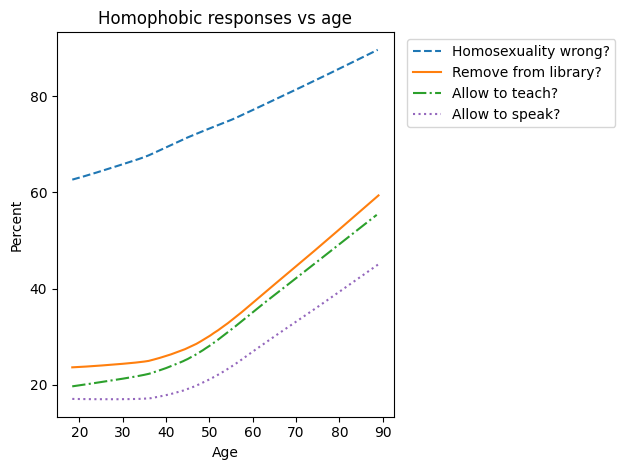

In [50]:
#figwidth = 3.835
#plt.figure(figsize=(figwidth, 0.7*figwidth))

plot_series_lowess(series_homosex, ls='--', color="C0", label="Homosexuality wrong?")
plot_series_lowess(series_libhomo, ls="-", color="C1", label="Remove from library?")
plot_series_lowess(series_colhomo, ls="-.", color="C2", label="Allow to teach?")
plot_series_lowess(series_spkhomo, ls=":", color="C4", label="Allow to speak?")

decorate(xlabel="Age", 
         ylabel="Percent", 
         title="Homophobic responses vs age")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.yticks([20, 40, 60, 80])
plt.tight_layout();

It comes as no surprise that older people are more likely to hold homophobic beliefs.
But that doesn't mean people adopt these attitudes as they age.
In fact, within every birth cohort, they become less homophobic with age.

The following figure show the results from the first question, showing the percentage of respondents who said homosexuality was wrong (with or without an adverb).

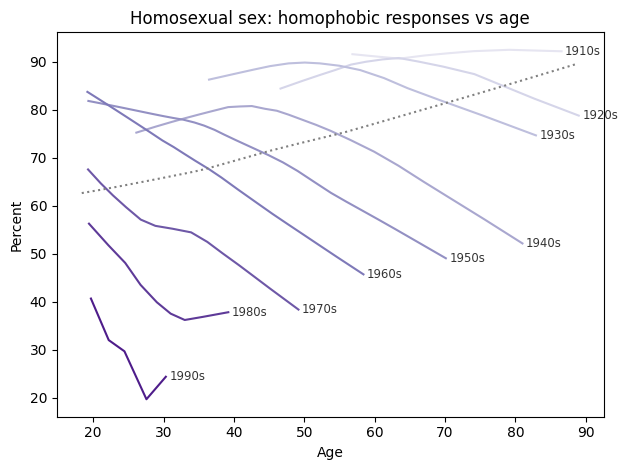

In [51]:
xvarname = "age"
yvarname = "homosex"
gvarname = "cohort10"
yvalue = [1, 2, 3]  # always, almost always, or sometimes wrong

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)
del table[1900]

visualize_table(series_homosex, table, plot_series=False)
nudge = {}
label_table(table, nudge)

decorate(
    xlabel="Age",
    ylabel="Percent",
    title="Homosexual sex: homophobic responses vs age",
    legend=False,
)

There is clearly a cohort effect: each generation is substantially less homophobic than the one before.
And in almost every cohort, homophobia declines with age.
But that doesn't mean there is an age effect; if there were, we would expect to see a change in all cohorts at about the same age. And there's no sign of that.

So let's see if it might be a period effect. The following figure shows the same results plotted over time rather than age.

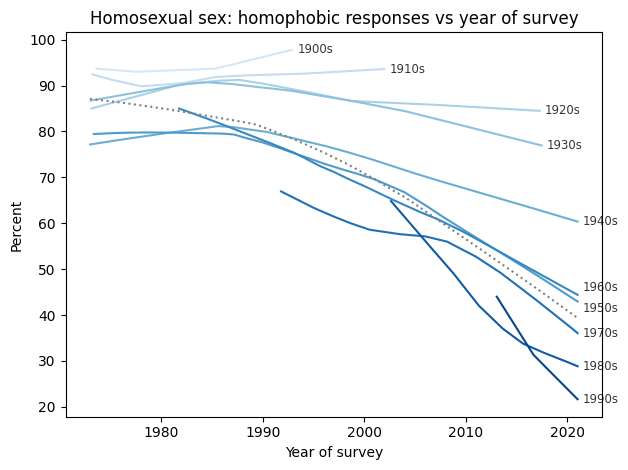

In [52]:
xvarname = "year"
yvarname = "homosex"
gvarname = "cohort10"
yvalue = [1, 2, 3]  # always, almost always, or sometimes wrong

table = make_table(gss, xvarname, yvarname, gvarname, yvalue)
#del table[1900]
series = chunk_series(gss, xvarname) * 100

visualize_table(series, table, plot_series=False, palette="Blues")
nudge = {"1960s": 1.5, "1950s": -1.5}
label_table(table, nudge)

decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Homosexual sex: homophobic responses vs year of survey",
    legend=False,
)

If there is a period effect, we expect to see an inflection point in all cohorts at the same point in time.
And there is some evidence of that.
Reading from top to bottom:

* More than 90% of people born in the nineteen-oughts and the teens thought homosexuality was wrong, and they went to their graves without changing their minds.

* People born in the 1920s and 1930s might have softened their views, slightly, starting around 1990.

* Among people born in the 1940s and 1950s, there is a notable inflection point: before 1990, they were almost unchanged; after 1990, they became more tolerant over time.

* In the last four cohorts, there is a clear trend over time, but we did not observe these groups sufficiently before 1990 to identify an inflection point.

On the whole, this looks like a period effect.
Also, looking at the overall trend, it declined slowly before 1990 and much more quickly thereafter. So we might wonder what happened in 1990.

## What happened in 1990?

In general, questions like this are hard to answer.
Societal changes are the result of interactions between many causes and effects.
But in this case, I think there is an explanation that is at least plausible: advocacy for acceptance of homosexuality has been successful at changing people's minds.

And as surveys by the Pew Research Center have shown repeatedly, "familiarity is closely linked to tolerance".
People who have a gay friend or family member -- and know it -- are substantially more likely to hold positive attitudes about homosexuality and to support gay rights.

All of this adds up to a large period effect that has changed hearts and minds, especially among the most recent birth cohorts.

## Cohort or period effect?

Since 1990, attitudes about homosexuality have changed due to

* A cohort effect: As old homophobes die, they are replaced by a more tolerant generation.

* A period effect: Within most cohorts, people became more tolerant over time.

These effects are additive, so the overall trend is steeper than the trend within the cohorts -- like Simpson's paradox in reverse.
But that raises a question: how much of the overall trend is due to the cohort effect, and how much to the period effect?

To answer that, I used a model that estimates the contributions of the two effects separately (a logistic regression model, if you want the details).
Then I used the model to generate predictions for two counterfactual scenarios: what if there had been no cohort effect, and what if there had been no period effect?
The following figure shows the results.

In [53]:
from utils import run_subgroups

xvarname = "year"
yvarname = "homosex"
gvarname = "cohort10"
yvalue = [1, 2, 3]

params = run_subgroups(gss, xvarname, yvarname, gvarname, yvalue)
params

,param,pvalue,stderr,conf_inf
all,-0.053473,0.000000e+00,0.000849,"[-0.055136580785341956, -0.05180871766455423]"
1890,-0.077745,2.273927e-01,0.064406,"[-0.20397916605784486, 0.04848906588701343]"
1900,0.014409,4.968642e-01,0.021207,"[-0.027156331546442668, 0.05597385504432175]"
1910,0.012017,2.122643e-01,0.009634,"[-0.006865391357516012, 0.030900275244131446]"
1920,-0.003934,4.294238e-01,0.004979,"[-0.013692910302871744, 0.005824344795135367]"
1930,-0.019788,1.624148e-08,0.003504,"[-0.026655061392608558, -0.012921134168900021]"
1940,-0.022016,1.562398e-24,0.002154,"[-0.026237215405072574, -0.01779534249912327]"
1950,-0.036704,3.419912e-88,0.001844,"[-0.04031711600258545, -0.03309033249908674]"
1960,-0.048013,2.788866e-86,0.002439,"[-0.05279249900744741, -0.043232586055901925]"
1970,-0.037391,5.531580e-26,0.003547,"[-0.04434277455112416, -0.030439309388739844]"


In [54]:
actual = chunk_series(gss, xvarname, size=1000) * 100

In [55]:
data = pd.DataFrame(
    dict(
        y=gss["y"],
        age=gss["age"],
        cohort=gss["cohort"],
        year=gss["year"],
    )
).query("year>=1987")

data.tail()

,y,age,cohort,year
68841,1.0,28.0,1993.0,2021
68842,NaN,23.0,1998.0,2021
68843,NaN,25.0,1996.0,2021
68844,0.0,41.0,1980.0,2021
68845,0.0,20.0,2001.0,2021


In [56]:
import statsmodels.formula.api as smf

formula = "y ~ year + cohort"
results = smf.logit(formula, data=data).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.570330
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28302
Model:                          Logit   Df Residuals:                    28299
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Jan 2024   Pseudo R-squ.:                  0.1139
Time:                        16:46:17   Log-Likelihood:                -16141.
converged:                       True   LL-Null:                       -18216.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    144.1172      2.634     54.712      0.000     138.954     149.280
year          -0.0458      0.001    -32.377      0.000      -0.049      -0.043
cohort        -0.0264      0.001    -31.728      0.000      -0.028      -0.025
==============================================================================
"""

In [57]:
data["predict"] = results.predict(data)
pred = data.groupby("year")["predict"].mean()

In [58]:
y = 1987
c = data.query("year==1987")["cohort"].mean()
b0, b1, b2 = results.params

In [59]:
from utils import make_counterfact

inter = b0 + b1 * y
cohort_only = make_counterfact(results, "year", inter, data) * 100

In [60]:
def error_func(inter):
    period_only = make_counterfact(results, "cohort", inter, data)
    return period_only[y] - pred[y]

In [61]:
g0 = b0 + b2 * c
error_func(g0)

0.00844600702268361

In [62]:
from scipy.optimize import fsolve

inter = fsolve(error_func, g0)
period_only = make_counterfact(results, "cohort", inter, data) * 100

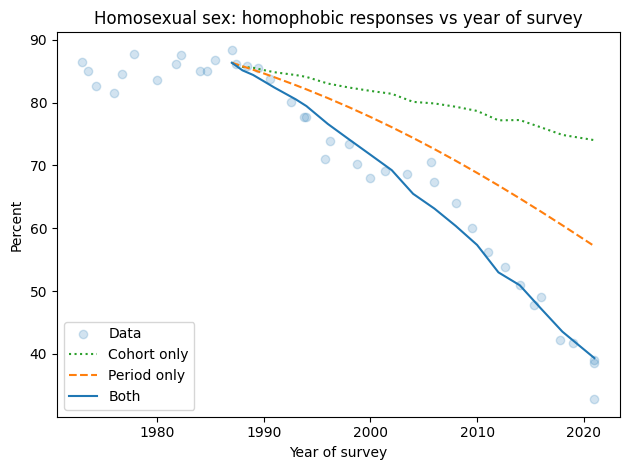

In [63]:
actual.plot(style="o", color="C0", alpha=0.2, label="Data")
cohort_only.plot(ls=":", color="C2", label="Cohort only")
period_only.plot(ls="--", color="C1", label="Period only")

(pred * 100).plot(color="C0", label="Both")

decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Homosexual sex: homophobic responses vs year of survey",
)

The circles show the actual data.
The solid line shows the results from the model from 1987 to 2018, including both effects.
The model plots a smooth course through the data, which confirms that it captures the overall trend during this interval.
The total change is about 46 percentage points.

The dotted line shows what would have happened, according to the model, if there had been no period effect; the total change due to the cohort effect alone would have been about 12 percentage points.

The dashed line shows what would have happened if there had been no cohort effect; the total change due to the period effect alone would have been about 29 percentage points.

You might notice that the sum of 12 and 29 is only 41, not 46.
That's not an error; in a model like this, we don't expect percentage points to add up (because it's linear on a logistic scale, not a percentage scale).

Nevertheless, we can conclude that the magnitude of the period effect is about twice the magnitude of the cohort effect.
In other words, most of the change we've seen since 1987 has been due to changed minds, with the smaller part due to generational replacement.

In [64]:
preds = np.array([pred[2021] * 100, cohort_only[2021], period_only[2021]])
preds

array([39.34462992, 74.02379242, 57.15543899])

In [65]:
diffs = pred[1987] * 100 - preds
diffs

array([46.99455201, 12.31538951, 29.18374294])

In [66]:
diffs / diffs[0]

array([1.        , 0.26205994, 0.62100268])

In [67]:
from scipy.special import logit

logits = logit(pred[1987] / 100) - logit(preds / 100)
logits

array([-4.31053677, -5.79059099, -5.0315813 ])

In [68]:
logits[0] - logits[1] - logits[2]

6.5116355129041334

## The Overton Window

In this chapter, we have considered three questions related to racism, three related to feminism, and four related to homosexuality.
For each question I characterized one or more responses as racist, sexist, or homophobic.
I realize that these terms are loaded with value judgments, but I think they are accurate. 
The view that interracial marriage should be illegal is racist.
The view that women are less suited to politics than men is sexist.
And the view that an "admitted" homosexual should not be allowed to teach at a university is homophobic.
Now, so we can put the results on the same $y$ axis, I will combine these responses into a group I will characterize as "bigoted".

The following figure shows how the the percentage of people choosing bigoted responses, for each of the ten questions we've looked at, has changed over time.

In [69]:
over_time = ten_questions.groupby("year").mean()
columns = over_time.columns

In [70]:
muted = sns.color_palette("muted", 10)
color_map = dict(zip(columns, muted))

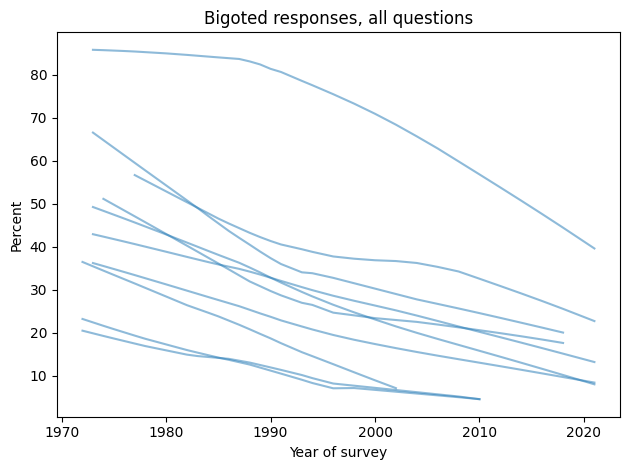

In [71]:
for column in columns:
    plot_series_lowess(over_time[column] * 100, ls="-", alpha=0.5)

decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Bigoted responses, all questions",
    legend=False,
)

I didn't label the lines because it doesn't matter for now which is which; the point is that they are all headed in the direction of decreasing bigotry.

I have smoothed the data, so we don't see short-term variation from year to year.
But the long-term trends are consistent; some speed up or slow down, but there are no long-term reversals.

When these questions were first asked in the 1970s, most of the percentages were between 20% and 60%.
That's not a coincidence; the topics and the wording of the questions were chosen to avoid very high and very low percentages, which are hard to measure accurately and less informative if you do.
There is not much point in asking whether murder is bad.

However, many of the views that were mainstream in the 1970s had become unpopular, or on the fringe, by the 2010s.
Three of the 10 questions were removed from the survey as they approached the territory of the lizard people, and several more are on their way out.

## Sources and related reading

* Planck's autobiography is called *Scientific autobiography and other papers* \cite{planck2014scientific}.

* William Lecky described the expanding moral circle in "History of European morals, from Augustus to Charlemagne" \cite{lecky1897history}. The philosopher Peter Singer wrote about it in *The expanding circle* \cite{singer1981}, as did Steven Pinker in *The better angels of our nature: Why violence has declined* \cite{pinker2012}. More recently, Sigal Samuel wrote an article on the topic for Vox \cite{samuel2019}.

* The General Social Survey (GSS) is a project of the independent research organization NORC at the University of Chicago, with principal funding from the National Science Foundation. The data is available from the GSS website \cite{gss2022}.

* Vox published an article about lizard people \cite{abadsantos2015}. Results from the lizard people poll are reported on the website of Public Policy Polling \cite{ppp2013}.

* The Pew Research study showing that familiarity breeds acceptance is "Four-in-Ten Americans Have Close Friends or Relatives Who are Gay" \cite{rosentiel2007}.

* You can see a performance of "A Message From the Gay Community" on YouTube \cite{sfgmc2021}. 

* *Politico Magazine* wrote about the origins of the Overton Window, and its use in popular culture \cite{robertson2018}. The example of alcohol prohibition is from the video, "The Overton Window of Political Possibility Explained" \cite{mackinac2020}.


Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).